## Public Holidays Impact

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

merged = pd.read_csv("E:/final_pharma_forcast/DATA/holidays (1).csv")

# Display options
pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 200)

# Ensure datetime, sort, drop dups
merged["datum"] = pd.to_datetime(merged["datum"])
merged = merged.sort_values("datum").drop_duplicates(subset=["datum"]).reset_index(drop=True)

# Identify sales columns (ATC codes)
pattern = re.compile(r"^[A-Z]\d{2}[A-Z]{0,2}$")   # matches R03, R06, N05B, N02BE, etc.
sales_cols = [c for c in merged.columns if pattern.match(c)]
if not sales_cols:  # fallback if regex misses
    sales_cols = ["M01AB","M01AE","N02BA","N02BE","N05B","N05C","R03","R06"]

# Identify holiday/calendar feature columns
holiday_cols = [c for c in merged.columns if c.startswith(("public_holiday","new_year","statehood_day","labor_day","armistice_day","orthodox_"))]
calendar_cols = [c for c in merged.columns if c in ["dow","weekofyear","month","quarter","cold_flu_season","pollen_season"]]

print("Sales columns:", sales_cols)
print("Holiday cols:", holiday_cols)
print("Calendar cols:", calendar_cols)


Sales columns: ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
Holiday cols: ['public_holiday', 'new_year', 'statehood_day', 'labor_day', 'armistice_day', 'orthodox_christmas', 'orthodox_easter_sunday', 'orthodox_easter_monday', 'orthodox_good_friday', 'orthodox_holy_saturday', 'public_holiday_window', 'orthodox_easter_sunday_window', 'orthodox_easter_monday_window', 'orthodox_good_friday_window', 'orthodox_holy_saturday_window']
Calendar cols: ['dow', 'weekofyear', 'month', 'quarter', 'cold_flu_season', 'pollen_season']


In [2]:
from scipy.stats import ttest_ind

for col in sales_cols:
    holiday_sales = merged[merged["public_holiday"]==1][col]
    normal_sales = merged[merged["public_holiday"]==0][col]
    t_stat, p_val = ttest_ind(holiday_sales, normal_sales, equal_var=False)
    print(f"{col} - p-value for holiday effect: {p_val:.4f}")


M01AB - p-value for holiday effect: 0.3011
M01AE - p-value for holiday effect: 0.0072
N02BA - p-value for holiday effect: 0.0036
N02BE - p-value for holiday effect: 0.1048
N05B - p-value for holiday effect: 0.0000
N05C - p-value for holiday effect: 0.0000
R03 - p-value for holiday effect: 0.0241
R06 - p-value for holiday effect: 0.2528


In [3]:
# Filter rows where N05B = 0
zero_sales = merged[merged["N05B"] == 0]

# Of these, check which are public holidays
zero_on_holiday = zero_sales[zero_sales["public_holiday"] == 1]

# Show relevant columns
cols_to_show = ["datum","N05B","public_holiday","public_holiday_window","dow"]
print(zero_on_holiday[cols_to_show])

          datum  N05B  public_holiday  public_holiday_window  dow
5    2014-01-07   0.0             1.0                    1.0  1.0
108  2014-04-20   0.0             1.0                    1.0  6.0
119  2014-05-01   0.0             1.0                    1.0  3.0
364  2015-01-01   0.0             1.0                    1.0  3.0
370  2015-01-07   0.0             1.0                    1.0  2.0
465  2015-04-12   0.0             1.0                    1.0  6.0
729  2016-01-01   0.0             1.0                    1.0  4.0
730  2016-01-02   0.0             1.0                    1.0  5.0
735  2016-01-07   0.0             1.0                    1.0  3.0
850  2016-05-01   0.0             1.0                    1.0  6.0
1096 2017-01-02   0.0             1.0                    1.0  0.0
1200 2017-04-16   0.0             1.0                    1.0  6.0
1215 2017-05-01   0.0             1.0                    1.0  0.0
1460 2018-01-01   0.0             1.0                    1.0  0.0
1466 2018-

In [4]:
# Filter rows where it's a public holiday
holiday_sales = merged[merged["public_holiday"]==1]

# Show relevant columns
cols_to_show = ["datum"] + sales_cols
print(holiday_sales[cols_to_show])


          datum  M01AB  M01AE  N02BA  N02BE  N05B  N05C  R03  R06
5    2014-01-07   0.00  0.000    0.0    0.0   0.0   0.0  0.0  0.0
44   2014-02-15   1.00  2.340    2.0   37.0   9.0   0.0  1.0  5.0
45   2014-02-16   0.00  1.680    1.2   34.0   5.0   2.0  3.0  1.0
46   2014-02-17   7.34  4.000   12.7   27.0  13.0   1.0  7.0  0.0
106  2014-04-18   7.00  7.000    8.0   23.3  10.0   1.0  0.0  5.0
...         ...    ...    ...    ...    ...   ...   ...  ...  ...
1941 2019-04-27  17.34  2.497    3.1   25.2  13.0   1.0  7.0  7.0
1942 2019-04-28   0.00  0.000    0.0    0.0   0.0   0.0  0.0  0.0
1943 2019-04-29   5.33  6.367    2.6   27.6   5.0   0.0  0.0  3.0
1945 2019-05-01   2.34  4.020    1.0    8.0   1.0   0.0  1.0  3.0
1946 2019-05-02   1.68  5.429    5.5   20.0  15.0   1.0  3.0  9.0

[72 rows x 9 columns]


In [5]:
# Add previous and next day sales for N05B
merged["N05B_prev"] = merged["N05B"].shift(1)
merged["N05B_next"] = merged["N05B"].shift(-1)

# Show holidays with surrounding sales
holiday_comparison = merged[merged["public_holiday"]==1][["datum","N05B","N05B_prev","N05B_next"]]
print(holiday_comparison)

          datum  N05B  N05B_prev  N05B_next
5    2014-01-07   0.0       16.0       19.0
44   2014-02-15   9.0       13.0        5.0
45   2014-02-16   5.0        9.0       13.0
46   2014-02-17  13.0        5.0       14.0
106  2014-04-18  10.0       19.0        7.0
...         ...   ...        ...        ...
1941 2019-04-27  13.0        6.0        0.0
1942 2019-04-28   0.0       13.0        5.0
1943 2019-04-29   5.0        0.0       13.0
1945 2019-05-01   1.0       13.0       15.0
1946 2019-05-02  15.0        1.0       11.0

[72 rows x 4 columns]


In [6]:
insights = []

for col in sales_cols:
    zero_sales = merged[merged[col] == 0]
    zero_on_holiday = zero_sales[zero_sales["public_holiday"] == 1]
    total_zeros = len(zero_sales)
    zeros_due_holiday = len(zero_on_holiday)
    pct_due_holiday = (zeros_due_holiday / total_zeros * 100) if total_zeros > 0 else 0
    insights.append({
        "Category": col,
        "Total Zero Sales Days": total_zeros,
        "Zero Sales on Holiday": zeros_due_holiday,
        "Pct Due to Holiday": round(pct_due_holiday, 1)
    })

insights_df = pd.DataFrame(insights)
insights_df


,Category,Total Zero Sales Days,Zero Sales on Holiday,Pct Due to Holiday
0,M01AB,40,17,42.5
1,M01AE,36,17,47.2
2,N02BA,78,16,20.5
3,N02BE,26,16,61.5
4,N05B,43,20,46.5
5,N05C,1430,59,4.1
6,R03,484,26,5.4
7,R06,256,22,8.6


In [7]:
holiday_effects = []

for col in sales_cols:
    avg_non_holiday = merged[merged["public_holiday"]==0][col].mean()
    avg_holiday = merged[merged["public_holiday"]==1][col].mean()
    drop = avg_non_holiday - avg_holiday
    pct_drop = (drop / avg_non_holiday * 100) if avg_non_holiday != 0 else 0
    holiday_effects.append({
        "Category": col,
        "Avg Sales Non-Holiday": round(avg_non_holiday,2),
        "Avg Sales Holiday": round(avg_holiday,2),
        "Sales Drop": round(drop,2),
        "% Drop": round(pct_drop,1)
    })

holiday_effects_df = pd.DataFrame(holiday_effects)
holiday_effects_df


,Category,Avg Sales Non-Holiday,Avg Sales Holiday,Sales Drop,% Drop
0,M01AB,5.05,4.54,0.51,10.1
1,M01AE,3.93,3.09,0.83,21.2
2,N02BA,3.91,2.92,0.99,25.4
3,N02BE,30.02,26.21,3.82,12.7
4,N05B,8.97,5.42,3.55,39.6
5,N05C,0.61,0.26,0.35,57.6
6,R03,5.56,4.10,1.46,26.2
7,R06,2.91,2.54,0.37,12.7


In [8]:
full_insights = insights_df.merge(holiday_effects_df, on="Category")
full_insights

,Category,Total Zero Sales Days,Zero Sales on Holiday,Pct Due to Holiday,Avg Sales Non-Holiday,Avg Sales Holiday,Sales Drop,% Drop
0,M01AB,40,17,42.5,5.05,4.54,0.51,10.1
1,M01AE,36,17,47.2,3.93,3.09,0.83,21.2
2,N02BA,78,16,20.5,3.91,2.92,0.99,25.4
3,N02BE,26,16,61.5,30.02,26.21,3.82,12.7
4,N05B,43,20,46.5,8.97,5.42,3.55,39.6
5,N05C,1430,59,4.1,0.61,0.26,0.35,57.6
6,R03,484,26,5.4,5.56,4.10,1.46,26.2
7,R06,256,22,8.6,2.91,2.54,0.37,12.7


### How to Read This Graph

- **Blue bars** (`% Zero Sales Due to Holiday`): percentage of zero-sales days for each drug category that occurred on public holidays.  
- **Orange bars** (`% Avg Sales Drop on Holiday`): percentage drop in average daily sales on holidays compared to non-holidays.  

**Key observations from this chart:**

1. **Highly holiday-sensitive categories:**  
   - `N02BE` → 61.5% of zero-sales days occur on holidays; sales drop ~12.7% on average.  
   - `N05B` → 46.5% zeros due to holidays; sales drop ~39.6%.  
   - `M01AE` → 47.2% zeros; sales drop ~21.2%.  

2. **Moderate holiday effect:**  
   - `M01AB` → 42.5% zeros; sales drop ~10.1%.  
   - `N02BA` → 20.5% zeros; sales drop ~25.4%.  

3. **Low holiday effect:**  
   - `N05C`, `R03`, `R06` → low percentage of zeros due to holidays (4–8.6%), but some show significant average sales drop (`N05C` drops 57.6%).  

**How to interpret:**  
- **Tall blue bar + tall orange bar:** many zero-sales days AND strong average sales drop → highly holiday-sensitive.  
- **Tall blue bar + short orange bar:** zeros occur mostly on holidays, but normal sales on non-zero days aren’t much affected.  
- **Short blue bar + tall orange bar:** zero-sales days are rare, but overall sales drop noticeably during holidays.  
- **Short blue bar + short orange bar:** minimal holiday effect.  

This chart allows you to **see both the frequency of zero-sales and the magnitude of sales decline** for each category, giving a full picture of holiday impact.


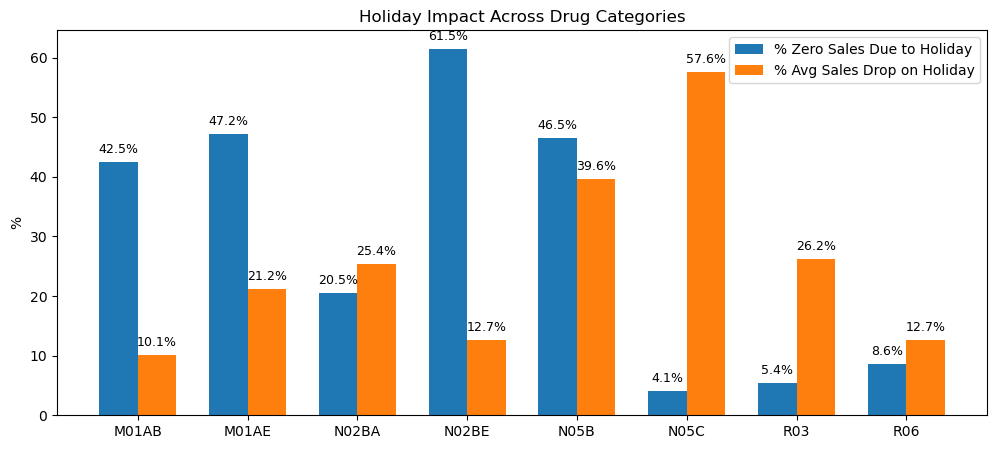

In [9]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(full_insights))
width = 0.35

fig, ax = plt.subplots(figsize=(12,5))
bars1 = ax.bar(x - width/2, full_insights["Pct Due to Holiday"], width, label='% Zero Sales Due to Holiday')
bars2 = ax.bar(x + width/2, full_insights["% Drop"], width, label='% Avg Sales Drop on Holiday')

# Add values on top of the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(full_insights["Category"])
ax.set_ylabel('%')
ax.set_title('Holiday Impact Across Drug Categories')
ax.legend()
plt.show()


## Cold and Flu Season Impact

In [10]:
season_corr = pd.DataFrame({
    "Cold/Flu Corr": merged[sales_cols + ["cold_flu_season"]].corr()["cold_flu_season"][sales_cols],
    "Pollen Corr": merged[sales_cols + ["pollen_season"]].corr()["pollen_season"][sales_cols]
})
season_corr

,Cold/Flu Corr,Pollen Corr
M01AB,-0.007259,-0.003894
M01AE,0.098658,-0.089206
N02BA,0.128690,-0.100082
N02BE,0.425770,-0.310427
N05B,0.100414,-0.083648
N05C,0.044074,-0.025508
R03,0.203565,-0.134338
R06,-0.385608,0.354858


### How to read this chart:

1. **Cold/Flu Corr (%)** (blue bars):
   - Positive correlation → sales **increase during cold/flu season** (Oct–Mar).
   - Example: 
       - **N02BE / N02BA** (Other analgesics and antipyretics, Pyrazolones and Anilides) show 42.6% correlation → higher demand during winter months when fever, flu, and pain are common.
       - **R03** (Respiratory drugs) also slightly rises due to cold-related symptoms.
   - Negative correlation (e.g., **R06**) indicates these drugs are **less needed during winter**.

2. **Pollen Corr (%)** (green bars):
   - Positive correlation → sales **increase during pollen season** (Apr–Jun, Aug–Sep), typically allergy season.
   - Example: 
       - **R06** (Antihistamines for systemic use) shows 35.5% correlation → spikes in spring/summer when pollen allergies are common.
   - Negative correlation indicates lower sales in allergy season.

3. **Key insights**:
   - **N02BE / N02BA** → winter demand spikes driven by fever, flu, and pain.
   - **R06** → spring/summer demand spikes driven by pollen and allergies.
   - Other categories show minor seasonal sensitivity.
   - Leveraging these seasonal flags helps in **forecasting, stock planning, and demand management** for season-driven drugs.


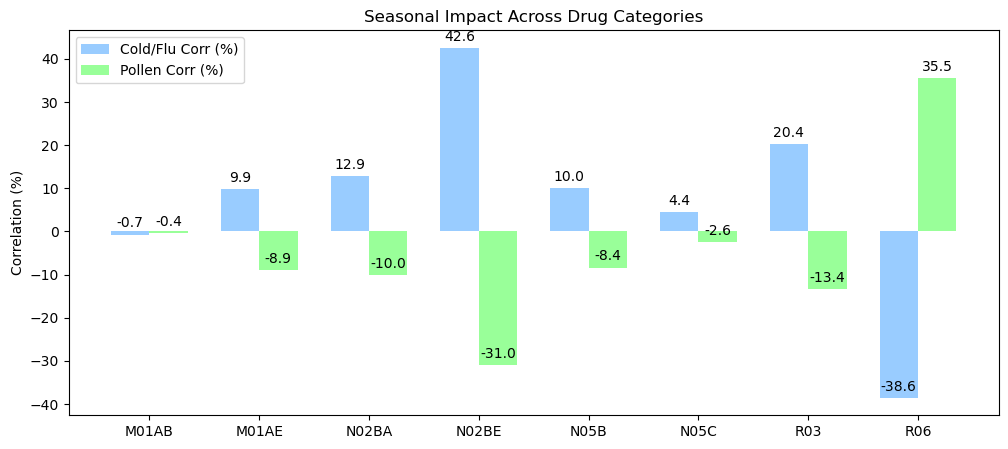

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(season_corr))
width = 0.35

fig, ax = plt.subplots(figsize=(12,5))

bars1 = ax.bar(x - width/2, season_corr["Cold/Flu Corr"]*100, width, label='Cold/Flu Corr (%)', color="#99CCFF")
bars2 = ax.bar(x + width/2, season_corr["Pollen Corr"]*100, width, label='Pollen Corr (%)', color="#99FF99")

ax.set_xticks(x)
ax.set_xticklabels(season_corr.index)
ax.set_ylabel('Correlation (%)')
ax.set_title('Seasonal Impact Across Drug Categories')
ax.legend()

# Annotate bar values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


# Extreme Peaks and Dips

In [12]:
from scipy.stats import zscore

extremes_list = []

for col in sales_cols:
    # Only non-holidays
    sales_non_holiday = merged.loc[merged["public_holiday"] == 0, ["datum", col]].copy()
    
    # Compute z-scores
    sales_non_holiday["zscore"] = zscore(sales_non_holiday[col].fillna(0))
    sales_non_holiday["drug_group"] = col
    
    # Keep only extreme events (|z| > 2)
    extreme_days = sales_non_holiday.loc[sales_non_holiday["zscore"].abs() > 2]
    
    extremes_list.append(extreme_days)

# Combine into one dataset
extremes_df = pd.concat(extremes_list).sort_values(["datum", "drug_group"])

extremes_df.head()

,datum,M01AB,zscore,drug_group,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
6,2014-01-08,NaN,2.787141,N02BA,NaN,10.5,NaN,NaN,NaN,NaN,NaN
9,2014-01-11,NaN,2.744827,N02BA,NaN,10.4,NaN,NaN,NaN,NaN,NaN
12,2014-01-14,NaN,3.548794,N02BA,NaN,12.3,NaN,NaN,NaN,NaN,NaN
16,2014-01-18,NaN,3.071143,N05C,NaN,NaN,NaN,NaN,4.0,NaN,NaN
21,2014-01-23,NaN,2.166181,N05C,NaN,NaN,NaN,NaN,3.0,NaN,NaN


In [13]:
from scipy.stats import zscore
import numpy as np
import pandas as pd

extremes_list = []

for col in sales_cols:
    # sales_non_holiday = merged[merged["public_holiday"]==0][col]
    # z_scores = zscore(sales_non_holiday, nan_policy="omit")  # handle NaNs safely
    
    # # Identify extreme values: peaks (z > 2) or dips (z < -2)
    # mask = (merged["public_holiday"]==0) & ((z_scores > 2) | (z_scores < -1.5))
    
    # extreme_days = merged.loc[mask, ["datum", col]].copy()

    sales_all = merged[col]  # include holidays
    z_scores = zscore(sales_all, nan_policy="omit")
    mask = ((z_scores > 2) | (z_scores < -1.5))
    extreme_days = merged.loc[mask, ["datum", col, "public_holiday"]]

    extreme_days["drug_group"] = col
    extreme_days["zscore"] = z_scores[mask]
    
    # Classify type of extreme
    extreme_days["extreme_type"] = np.where(
        extreme_days["zscore"] > 2, "high_peak", "low_dip"
    )
    
    # Rename col to "sales" for clarity
    extreme_days = extreme_days.rename(columns={col: "sales"})
    extremes_list.append(extreme_days)

# Combine into one DataFrame
extremes_long = pd.concat(extremes_list, ignore_index=True)

# Sort by date + extreme level
extremes_long = extremes_long.sort_values(["datum", "zscore"], ascending=[True, False])

# Check distribution
extremes_long.head()


,datum,sales,public_holiday,drug_group,zscore,extreme_type
0,2014-01-02,0.00,NaN,M01AB,-1.839172,low_dip
905,2014-01-03,20.00,NaN,R03,2.254126,high_peak
502,2014-01-04,61.85,NaN,N02BE,2.048654,high_peak
632,2014-01-07,0.00,1.0,N05B,-1.579799,low_dip
319,2014-01-07,0.00,1.0,N02BA,-1.628081,low_dip


In [14]:
extremes_long['extreme_type'].value_counts()

extreme_type
high_peak    795
low_dip      347
Name: count, dtype: int64

In [15]:
extremes_long[extremes_long['public_holiday']==1]['extreme_type'].value_counts()

extreme_type
low_dip      92
high_peak    21
Name: count, dtype: int64

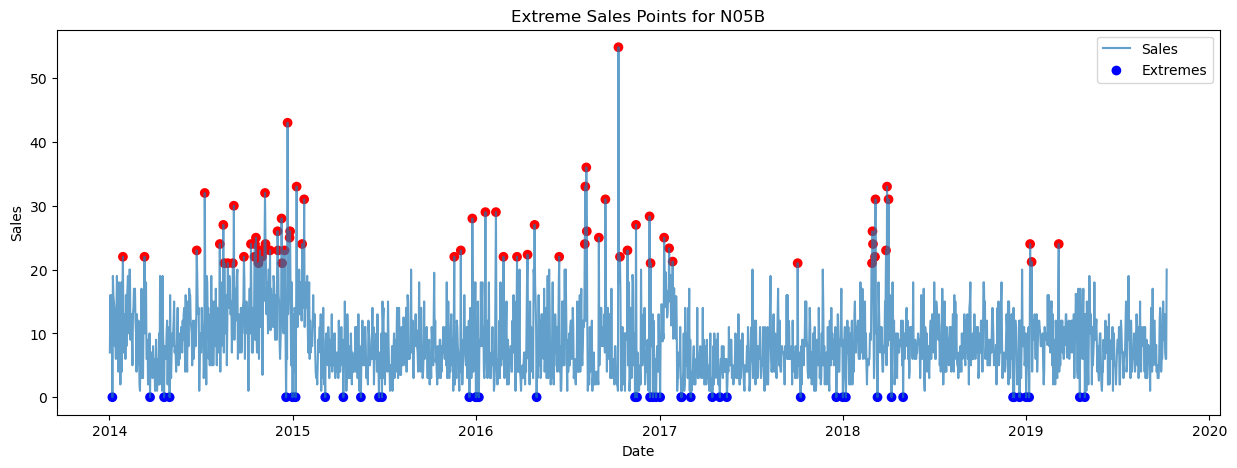

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
daily = pd.read_csv("E:/final_pharma_forcast/DATA/salesdaily.csv", parse_dates=["datum"])
# extremes_long = pd.read_csv("extremes_long.csv", parse_dates=["datum"])  # assuming you've saved it

# Choose product/category
product = "N05B"  # change to any sales column
series = daily[["datum", product]].set_index("datum")

# Filter extreme points for this product
extreme_points = extremes_long[extremes_long["drug_group"] == product]

plt.figure(figsize=(15,5))
plt.plot(series.index, series[product], label="Sales", alpha=0.7)

plt.scatter(
    extreme_points["datum"], 
    extreme_points["sales"], 
    c=extreme_points["extreme_type"].map({"high_peak": "red", "low_dip": "blue"}), 
    label="Extremes"
)

plt.title(f"Extreme Sales Points for {product}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [18]:
# Count high peaks and low dips
extreme_counts = extremes_long.groupby(['drug_group', 'extreme_type']).size().unstack(fill_value=0)
extreme_counts

extreme_type,high_peak,low_dip
drug_group,,
M01AB,71,67
M01AE,78,103
N02BA,84,99
N02BE,95,35
N05B,70,43
N05C,160,0
R03,124,0
R06,113,0


In [19]:
# Add holiday_type to merged
holiday_cols = [
    'new_year', 'statehood_day', 'labor_day', 'armistice_day',
    'orthodox_christmas', 'orthodox_easter_sunday', 'orthodox_easter_monday',
    'orthodox_good_friday', 'orthodox_holy_saturday'
]

def get_holiday_type(row):
    for col in holiday_cols:
        if row[col] == 1:
            return col
    if row['public_holiday'] == 1:
        return 'unknown'
    return None

merged['holiday_type'] = merged.apply(get_holiday_type, axis=1)


In [20]:
# Drop old holiday/season columns in extremes_long before merging
extremes_long = extremes_long.drop(columns=[col for col in extremes_long.columns 
                                            if col in ['public_holiday','holiday_type','cold_flu_season','pollen_season']], errors='ignore')

# Now merge fresh data from merged
merge_cols = ['datum', 'public_holiday', 'holiday_type', 'cold_flu_season', 'pollen_season']

extremes_long = extremes_long.merge(
    merged[merge_cols],
    on='datum',
    how='left'
)

# Group by drug, extreme type, and holiday / season
holiday_extreme = extremes_long.groupby(['drug_group','extreme_type','public_holiday']).size().unstack(fill_value=0)
cold_flu_extreme = extremes_long.groupby(['drug_group','extreme_type','cold_flu_season']).size().unstack(fill_value=0)
pollen_extreme = extremes_long.groupby(['drug_group','extreme_type','pollen_season']).size().unstack(fill_value=0)

holiday_extreme, cold_flu_extreme, pollen_extreme


(public_holiday           0.0  1.0
 drug_group extreme_type          
 M01AB      high_peak      64    7
            low_dip        46   20
 M01AE      high_peak      76    2
            low_dip        85   18
 N02BA      high_peak      82    2
            low_dip        83   16
 N02BE      high_peak      90    4
            low_dip        17   18
 N05B       high_peak      70    0
            low_dip        23   20
 N05C       high_peak     160    0
 R03        high_peak     121    2
 R06        high_peak     109    4,
 cold_flu_season          0.0  1.0
 drug_group extreme_type          
 M01AB      high_peak      39   32
            low_dip        31   35
 M01AE      high_peak      30   48
            low_dip        58   45
 N02BA      high_peak      21   63
            low_dip        50   49
 N02BE      high_peak      10   84
            low_dip        15   20
 N05B       high_peak      19   51
            low_dip        14   29
 N05C       high_peak      78   82
 R03        high_pe

In [21]:
# Count of high peaks + low dips per drug
volatility = extremes_long.groupby('drug_group')['extreme_type'].value_counts().unstack(fill_value=0)
volatility['total_extremes'] = volatility['high_peak'] + volatility['low_dip']
volatility = volatility.sort_values('total_extremes', ascending=False)
volatility

extreme_type,high_peak,low_dip,total_extremes
drug_group,,,
N02BA,84,99,183
M01AE,78,103,181
N05C,160,0,160
M01AB,71,67,138
N02BE,95,35,130
R03,124,0,124
N05B,70,43,113
R06,113,0,113


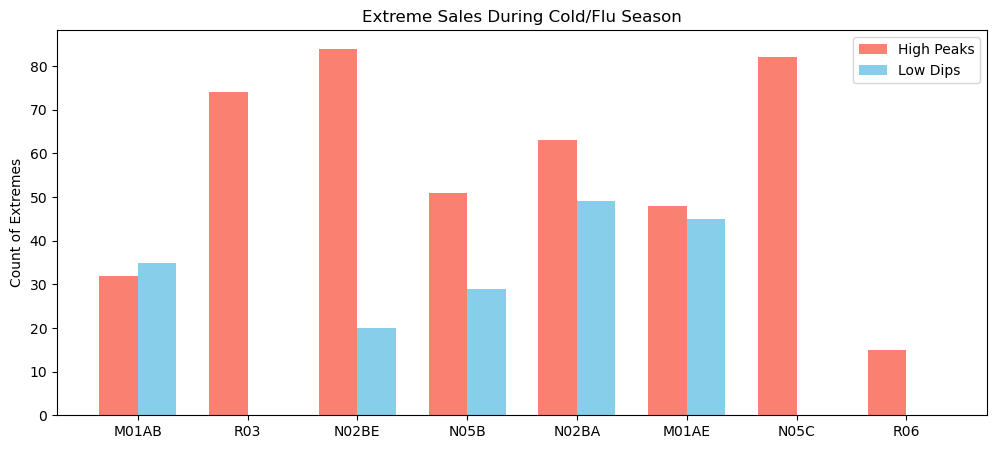

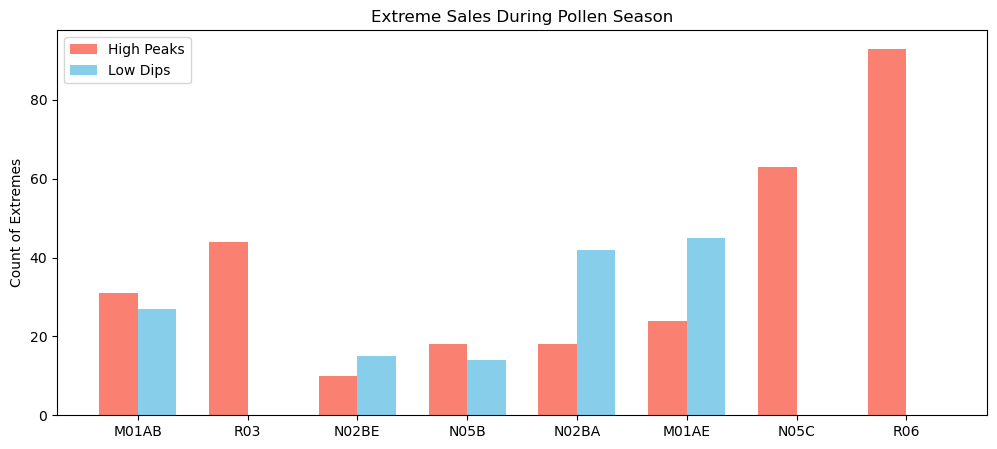

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get drug categories
drug_categories = extremes_long['drug_group'].unique()

# Cold/Flu season
cold_high = [cold_flu_extreme.loc[(drug, 'high_peak'), 1.0] if (drug, 'high_peak') in cold_flu_extreme.index else 0 for drug in drug_categories]
cold_low  = [cold_flu_extreme.loc[(drug, 'low_dip'), 1.0]  if (drug, 'low_dip')  in cold_flu_extreme.index else 0 for drug in drug_categories]

# Pollen season
pollen_high = [pollen_extreme.loc[(drug, 'high_peak'), 1.0] if (drug, 'high_peak') in pollen_extreme.index else 0 for drug in drug_categories]
pollen_low  = [pollen_extreme.loc[(drug, 'low_dip'), 1.0]  if (drug, 'low_dip')  in pollen_extreme.index else 0 for drug in drug_categories]

x = np.arange(len(drug_categories))
width = 0.35

# Plot Cold/Flu season
fig, ax = plt.subplots(figsize=(12,5))
ax.bar(x - width/2, cold_high, width, label='High Peaks', color='salmon')
ax.bar(x + width/2, cold_low, width, label='Low Dips', color='skyblue')
ax.set_xticks(x)
ax.set_xticklabels(drug_categories)
ax.set_ylabel('Count of Extremes')
ax.set_title('Extreme Sales During Cold/Flu Season')
ax.legend()
plt.show()

# Plot Pollen season
fig, ax = plt.subplots(figsize=(12,5))
ax.bar(x - width/2, pollen_high, width, label='High Peaks', color='salmon')
ax.bar(x + width/2, pollen_low, width, label='Low Dips', color='skyblue')
ax.set_xticks(x)
ax.set_xticklabels(drug_categories)
ax.set_ylabel('Count of Extremes')
ax.set_title('Extreme Sales During Pollen Season')
ax.legend()
plt.show()

In [23]:
import pandas as pd

def calc_percentages(df, condition_col, condition_name):
    # Count events by extreme type and condition
    counts = df.groupby([condition_col, "extreme_type"]).size().reset_index(name="count")

    # Total extremes (for percentage)
    total_extremes = counts["count"].sum()

    # Add percentage out of all extremes
    counts["percentage_total"] = 100 * counts["count"] / total_extremes

    print(f"\n=== {condition_name} ===")
    print(counts)

    return counts

# Run for each condition
holiday_perc = calc_percentages(extremes_long, "public_holiday", "Public Holiday")
cold_perc    = calc_percentages(extremes_long, "cold_flu_season", "Cold/Flu Season")
pollen_perc  = calc_percentages(extremes_long, "pollen_season", "Pollen Season")



=== Public Holiday ===
   public_holiday extreme_type  count  percentage_total
0             0.0    high_peak    772         67.778753
1             0.0      low_dip    254         22.300263
2             1.0    high_peak     21          1.843723
3             1.0      low_dip     92          8.077261

=== Cold/Flu Season ===
   cold_flu_season extreme_type  count  percentage_total
0              0.0    high_peak    344         30.201932
1              0.0      low_dip    168         14.749781
2              1.0    high_peak    449         39.420544
3              1.0      low_dip    178         15.627744

=== Pollen Season ===
   pollen_season extreme_type  count  percentage_total
0            0.0    high_peak    492         43.195786
1            0.0      low_dip    203         17.822651
2            1.0    high_peak    301         26.426690
3            1.0      low_dip    143         12.554873


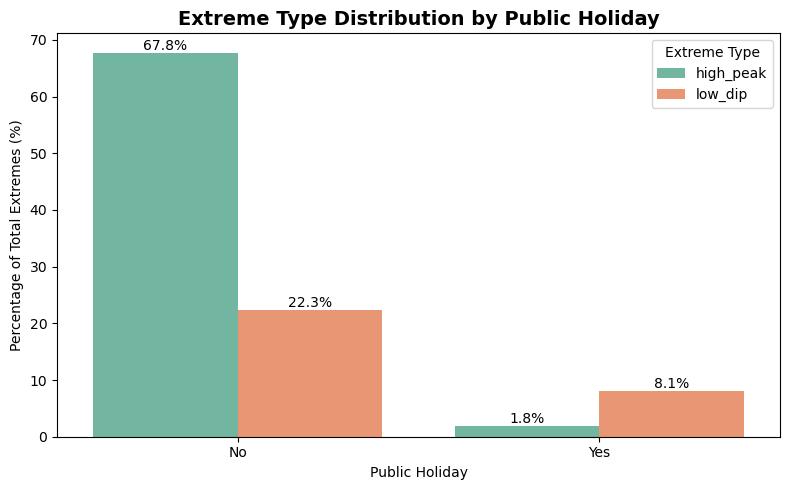

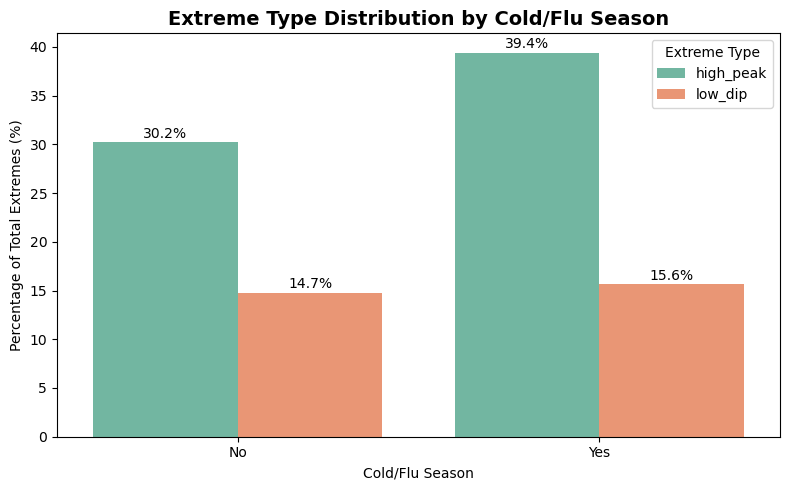

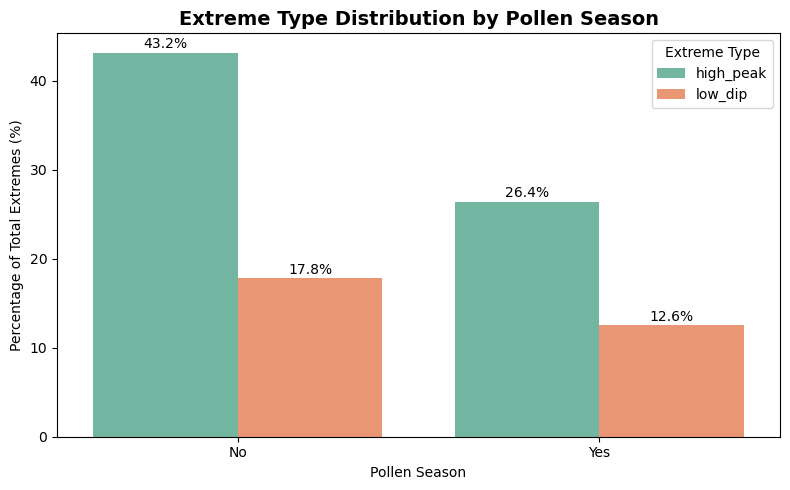

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_percentages(df, condition_col, condition_name):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df,
        x=condition_col,
        y="percentage_total",
        hue="extreme_type",
        palette="Set2"
    )
    
    plt.title(f"Extreme Type Distribution by {condition_name}", fontsize=14, weight="bold")
    plt.xlabel(condition_name)
    plt.ylabel("Percentage of Total Extremes (%)")
    plt.xticks([0, 1], ["No", "Yes"])  # Replace 0/1 with readable labels
    
    # Show values on top of bars
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().text(
                p.get_x() + p.get_width()/2., 
                height + 0.5,
                f"{height:.1f}%", 
                ha="center"
            )
    
    plt.legend(title="Extreme Type")
    plt.tight_layout()
    plt.show()

# Plot for each condition
plot_percentages(holiday_perc, "public_holiday", "Public Holiday")
plot_percentages(cold_perc, "cold_flu_season", "Cold/Flu Season")
plot_percentages(pollen_perc, "pollen_season", "Pollen Season")


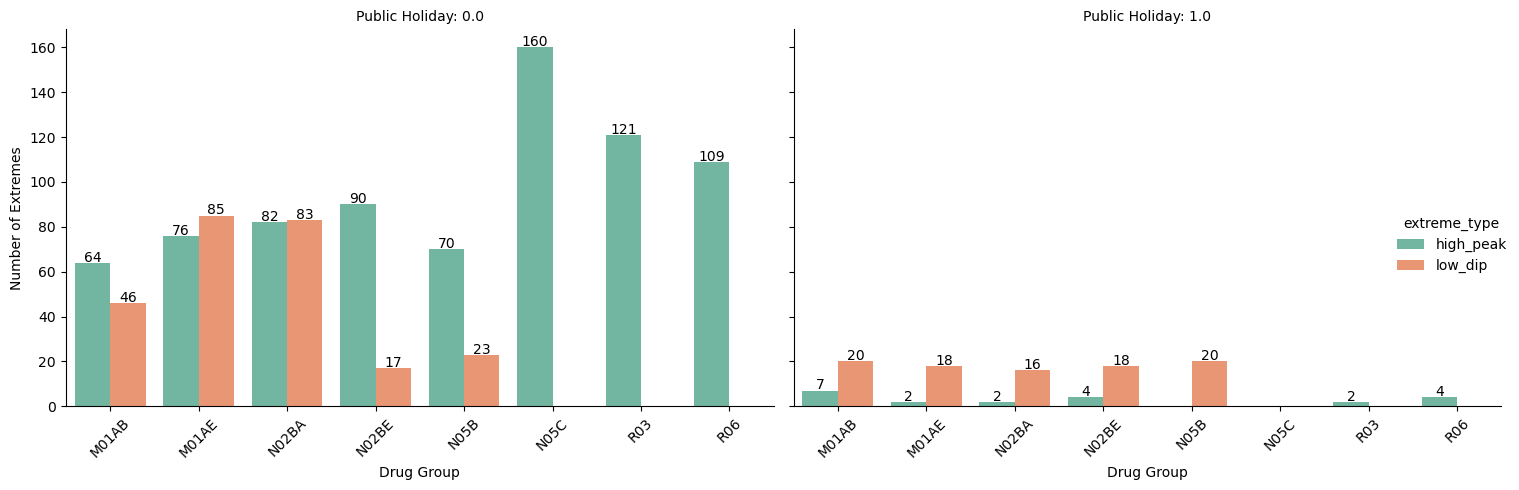

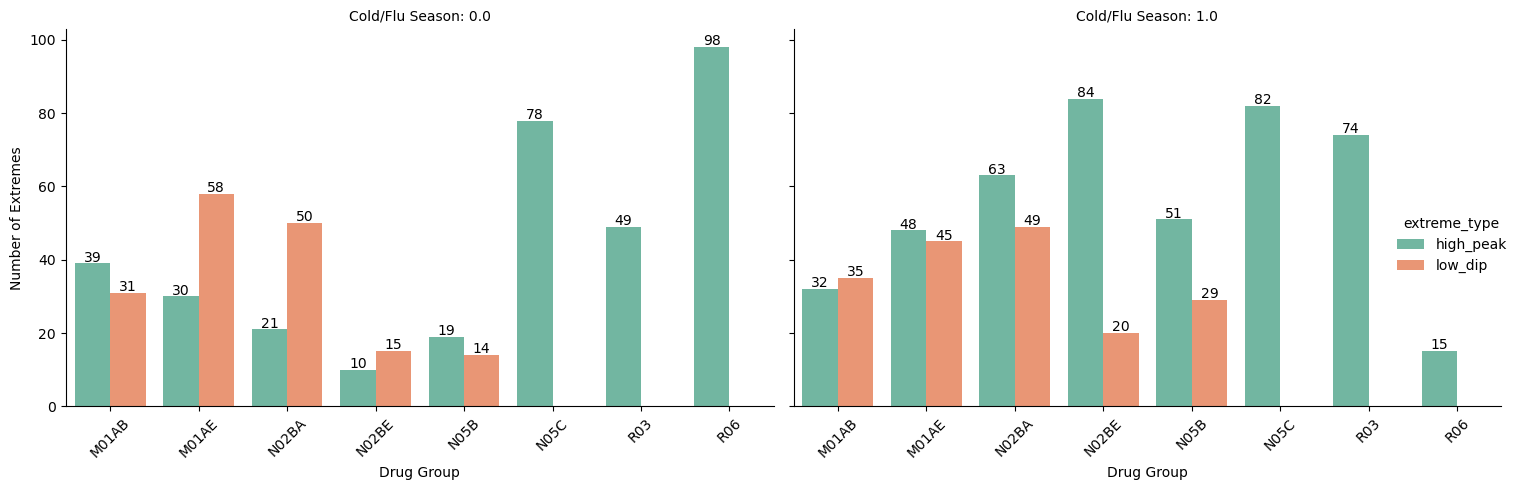

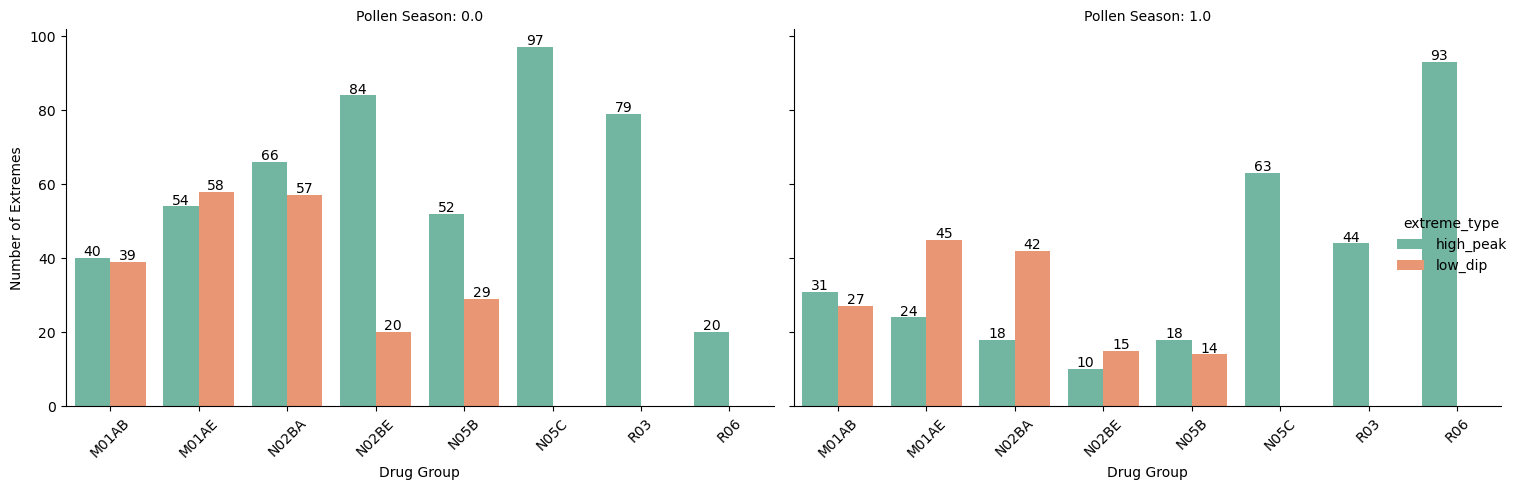

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_drug_group_breakdown(df, condition_col, condition_name):
    # Count per drug group, condition, and extreme type
    counts = (
        df.groupby([condition_col, "drug_group", "extreme_type"])
          .size()
          .reset_index(name="count")
    )

    # Plot
    g = sns.catplot(
        data=counts,
        x="drug_group",
        y="count",
        hue="extreme_type",
        col=condition_col,
        kind="bar",
        palette="Set2",
        height=5,
        aspect=1.4
    )
    
    g.set_axis_labels("Drug Group", "Number of Extremes")
    g.set_titles(f"{condition_name}: {{col_name}}")  # col_name will be 0 or 1
    g.set_xticklabels(rotation=45)
    
    # Add values on top of bars
    for ax in g.axes.flat:
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(
                    p.get_x() + p.get_width()/2.,
                    height + 0.5,
                    f"{int(height)}",
                    ha="center"
                )
    plt.tight_layout()
    plt.show()

# Run for each condition
plot_drug_group_breakdown(extremes_long, "public_holiday", "Public Holiday")
plot_drug_group_breakdown(extremes_long, "cold_flu_season", "Cold/Flu Season")
plot_drug_group_breakdown(extremes_long, "pollen_season", "Pollen Season")
